# 第3章 空域滤波

- 空域滤波（Spatial Domain Filtering），计算每个像素的滤波输出时，将会用到自身及其邻域像素的灰度值。
- 像素的邻域，是指以该像素为中心一定空间范围内像素的集合，例如，在第1章介绍的4-邻域、m×n矩形邻域等。
- 空域是指图像平面，空域图像增强就是直接修改像素值的处理方法。
- 灰度变换和空域滤波都属于空域图像增强，图像的平滑和锐化就属于空域滤波方法。
- 目前火爆的深度学习所用的卷积神经网络CNN（Convolutional Neural Networks），其核心结构就是基于各类空域滤波器。
- 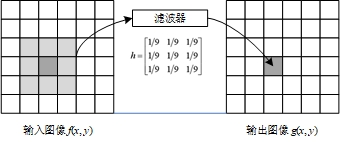

In [ ]:
#导入本章示例所用到的包,使用本文档中示例,先运行一次本段代码
import numpy as np
import cv2 as cv
from scipy import ndimage
from skimage import io,util,exposure,filters,morphology,color
import matplotlib.pyplot as plt
%matplotlib inline

## 3.2线性滤波器
- 线性滤波器在某一像素处的滤波输出，是该像素指定邻域内所有像素灰度值的线性组合，即加权求和。
- 线性滤波器的工作流程可分为以下几个环节：
    - 滤波器设计，确定滤波器作用区域的形状、尺寸及滤波器系数。
    - 对于图像中的每个像素(x,y)，依据该像素的坐标(x, y)和滤波器作用区域的形状、尺寸，确定其邻域内参与运算的像素及其坐标。
    - 将参与运算的像素灰度值与其对应滤波器系数相乘，并累加求和，得到像素(x,y)的滤波输出。


### 3.2.3 图像边界的处理
- 展示空域滤波采用的4种图像边界扩展方法
- 构造一个简单的3行*3列图像数据
- 以5*5滤波器为例，分别采用⑴填充常值⑵边界复制⑶边界镜像⑷周期延拓


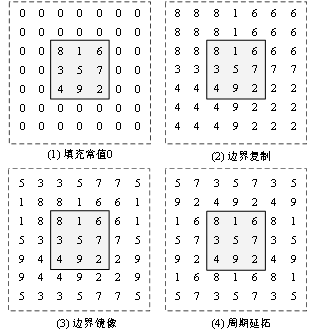

In [ ]:
#空域滤波采用的4种图像边界扩展方法
#构造3*3数组
a = np.array([[8,1,6],[3,5,7],[4,9,2]])

#扩展填充数组
#填充常值0
b = np.pad(a, ((2, 2), (2, 2)), 'constant', constant_values=0)
#边界复制
c = np.pad(a, ((2, 2), (2, 2)),'edge')
#边界镜像
d = np.pad(a, ((2, 2), (2, 2)),'symmetric')
#周期延拓
e = np.pad(a, ((2, 2), (2, 2)),'wrap')

#显示结果
print('a=\n',a)
print('填充常值,b=\n',b)
print('边界复制,c=\n',c)
print('边界镜像,d=\n',d)
print('周期延拓,e=\n',e)

### 3.2.4 线性空域滤波器的实现

## 示例：采用Python实现线性空域滤波-原理说明
- Implementing Convolutions with Python

In [ ]:
def convolve(image, kernel):
    """
    convolve 计算图像与滤波核的线性卷积 V1.0,2021-10
    输入参数:
        image - 二维数组，灰度图像；
       kernel - 二维数组，滤波核系数,方形，如3×3,5×5等.                
    返回值：
       output - 二维数组，滤波后得到的灰度图像   
    """
    # 获取输入图像核滤波核的尺寸大小（高、宽）
    (iH, iW) = image.shape[:2]
    (kH, kW) = kernel.shape[:2]

    #初始化输出图像数组变量
    output = np.zeros((iH, iW), dtype="float")
    #计算图像边界扩展参数
    padsize = (kW - 1) // 2
    
    #扩展图像边界，方式为边界复制
    image = cv.copyMakeBorder(image, padsize, padsize, padsize, padsize, cv.BORDER_REPLICATE)
    #填充0扩展图像
    #image = cv.copyMakeBorder(image, padsize, padsize, padsize, padsize, cv.BORDER_CONSTANT,value=0)
 
    
    #自左到右、自上而下滑动滤波核，遍历每个像素坐标(x, y)     
    for x in np.arange(padsize, iH + padsize):
        for y in np.arange(padsize, iW + padsize):
            #抽取以像素(x, y)为中心的邻域图像,图像区域尺寸与滤波核kernel大小相同
            roi = image[x - padsize:x + padsize + 1, y - padsize:y + padsize + 1]
            #将抽取的邻域像素与对应的滤波核系数相乘,再累加,得到像素(x, y)的卷积输出            
            output[x - padsize, y - padsize] = (roi.astype("float") * kernel).sum()
           
    # 将输出图像结果做饱和处理,数据类型转换为uint8
    output = np.clip(output,0,255).astype("uint8")
    #返回输出图像
    return output

In [ ]:
#调用自定义函数平滑图像
#读入一幅灰度图像
img = cv.imread('./imagedata/eight.tif',cv.IMREAD_GRAYSCALE)

#构造一个大小为5×5的均值滤波核
kav5 = np.ones((5, 5), np.float32) / 25

img_blur = convolve(img, kav5)

#显示结果
plt.figure(figsize=(12,6))
plt.gray()

#原图像
plt.subplot(1,2,1); plt.imshow(img,vmin=0,vmax=255)
plt.title('Original image ') 
plt.axis('off')
#均值滤波结果
plt.subplot(1,2,2); plt.imshow(img_blur,vmin=0,vmax=255)
plt.title('smoothed image')  
plt.axis('off')

plt.show()

### OpenCV线性空域滤波器cv.filter2D

- OpenCV库函数cv.filter2D()用于实现图像的线性空域滤波，该函数计算任意线性滤波核kernel与输入图像src的相关运算。当滤波核中心对称时，相关运算和卷积运算的结果相同。
- 需要注意的是，当滤波核kernel的尺寸小于11×11时，该函数直接采用相关运算，否则，将采用基于DFT的频域滤波算法。

### 示例：使用函数cv.filter2D对图像进行平滑滤波
- 构造一个大小55均值滤波器，调用cv.filter2D函数及其默认选项，对eight.tif灰度图像进行平滑滤波，默认采用“边界镜像”方式扩张图像边界，结果图像出现一定程度的模糊。
- 如果选择cv.BORDER_CONSTANT，即填充常值0（黑色）扩展图像边界，造成输出图像四周出现黑色边缘。

In [ ]:
#OpenCV线性空域滤波-灰度图像

#读入一幅灰度图像
img = cv.imread('./imagedata/eight.tif',cv.IMREAD_GRAYSCALE)

w = 5
#构造一个大小为5×5的均值滤波核
kav5 = np.ones((w, w), np.float32) / (w*w)

#采用默认边界扩展方式-边界镜像
img_smoothed1 = cv.filter2D(img, -1, kernel=kav5)
#采用填充常值0扩展边界
img_smoothed2 = cv.filter2D(img, -1, kernel=kav5 ,borderType=cv.BORDER_CONSTANT)

#显示结果
plt.figure(figsize=(16,8))
plt.gray()

#原图像
plt.subplot(1,3,1); plt.imshow(img,vmin=0,vmax=255)
plt.title('Original') 
plt.axis('off')
#均值滤波结果
plt.subplot(1,3,2); plt.imshow(img_smoothed1,vmin=0,vmax=255)
plt.title('smoothed, border reflect')  
plt.axis('off')

plt.subplot(1,3,3); plt.imshow(img_smoothed2,vmin=0,vmax=255)
plt.title('smoothed,border padding 0')
plt.axis('off')

plt.show()

In [ ]:
#OpenCV线性空域滤波-彩色图像

#读入一幅彩色图像
img = cv.imread('./imagedata/baboon.jpg',cv.IMREAD_COLOR)

h = 35
#构造一个大小为5×5的均值滤波核
kav5 = np.ones((h, h), np.float32) / (h*h)

#计算滤波核与图像的卷积(相关运算) 
#边界反射（默认）
img_smoothed = cv.filter2D(img, -1, kav5)

#显示结果
plt.figure(figsize=(12,6))
#彩色图像
plt.subplot(1,2,1); plt.imshow(img[:,:,::-1])
plt.title('Original') 
plt.axis('off')
#彩色图像滤波结果
plt.subplot(1,2,2); plt.imshow(img_smoothed[:,:,::-1])
plt.title('smoothed, border reflect') 
plt.axis('off')

plt.show()

In [ ]:
#cv.imwrite('baboon_blurred.jpg', img_smoothed, [cv.IMWRITE_JPEG_QUALITY,100])

### SciPy线性空域滤波器,线性卷积ndimage.convolve
##### 边界扩展方式是用0（黑色）填充扩展图像，造成输出图像四周出现了模糊的黑色边缘。如果使用默认'reflect'边界反射扩展方式选项,就不会出现上述“黑边”问题.

In [ ]:
#SciPy线性空域滤波-灰度图像

#读入一幅灰度图像
img = io.imread('./imagedata/eight.tif')

#构造一个大小为5×5的均值滤波核
kav5 = np.ones((5, 5), np.float32) / 25

#计算滤波核与图像的卷积
#默认reflect边界反射扩展方式
img_smoothed1 = ndimage.convolve(img,kav5)
#选择constant常数填充扩展方式，填充值为0
img_smoothed2 = ndimage.convolve(img,kav5 ,mode='constant',cval=0)



#显示结果
plt.figure(figsize=(16,8))
plt.gray()

#原图像
plt.subplot(1,3,1); plt.imshow(img,vmin=0,vmax=255)
plt.title('Original') 
plt.axis('off')

#灰度图像滤波结果,默认reflect边界反射扩展方式
plt.subplot(1,3,2); plt.imshow(img_smoothed1,vmin=0,vmax=255)
plt.title('smoothed_reflect_SciPy') 
plt.axis('off')

#灰度图像滤波结果,选择constant常数填充扩展方式，填充值为0
plt.subplot(1,3,3); plt.imshow(img_smoothed2,vmin=0,vmax=255)
plt.title('smoothed_constant_0_SciPy') 
plt.axis('off')

plt.show()

In [ ]:
#SciPy线性空域滤波-彩色图像

#读入一幅彩色图像
img = io.imread('./imagedata/baboon.jpg')

#构造一个大小为5×5的均值滤波核
kav5 = np.ones((5, 5), np.float32) / 25
#构造用于彩色图像的5×5的均值滤波核
a0 = np.zeros((5, 5), np.float32)
#与两个0数组堆叠为5×5×3的滤波器系数数组
kav5c = np.dstack((a0,kav5,a0))

#计算滤波核与图像的卷积
#选择constant常数填充扩展方式，填充值为0
img_smoothed_c0 = ndimage.convolve(img,kav5c ,mode='constant',cval=0)
#默认reflect边界反射扩展方式
img_smoothed_r = ndimage.correlate(img,kav5c)

#显示结果
plt.figure(figsize=(16,8))

#彩色图像
plt.subplot(1,3,1); plt.imshow(img)
plt.title('Original') 
plt.axis('off')
#彩色图像滤波结果,选择constant常数填充扩展方式，填充值为0
plt.subplot(1,3,2); plt.imshow(img_smoothed_c0)
plt.title('smoothed_constant_0_SciPy') 
plt.axis('off')
#彩色图像滤波结果,默认reflect边界反射扩展方式
plt.subplot(1,3,3); plt.imshow(img_smoothed_r)
plt.title('smoothed_reflect_SciPy') 
plt.axis('off')

plt.show()

## 3.3统计排序滤波器
### 3.3.1 最大值/最小值滤波器
- skimage.filters.rank.maximum(image, selem, out=None, mask=None, shift_x=False, shift_y=False)
- skimage.filters.rank.minimum(image, selem, out=None, mask=None, shift_x=False, shift_y=False)
- scipy.ndimage.maximum_filter(input, size=None, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
- scipy.ndimage.minimum_filter(input, size=None, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)

- 向图像中添加随机噪声
    - skimage.util.random_noise(image, mode='gaussian', seed=None, clip=True, **kwargs)

### 示例：图像最大值/最小值滤波

- 最大值滤波器适合去除图像中的黑色噪点（低灰度值的脉冲噪声），但同时会造成图像中暗色区域因边缘像素变亮而缩小、白色区域因周边背景像素变亮而扩大，从而导致图像整体偏亮。
- 最小值滤波器适合去除图像中的白色噪点（高灰度值的脉冲噪声），与最大值滤波器相反，它同时会造成图像中白色区域因边缘像素变暗而缩小、暗色区域因周边背景像素变暗而扩大，从而导致图像整体偏暗。

In [ ]:
#SciPy非线性空域滤波器--最大值/最小值滤波

#读入一幅灰度图像
img = io.imread('./imagedata/eight.tif')

#调用Scikit-image函数向图像中添加椒噪声,密度为0.1
img_noise1 = util.random_noise(img,mode='pepper',amount=0.1)
#将数据类型转换为uint8
img_noise1 = util.img_as_ubyte(img_noise1)

#调用Scikit-image函数向图像中添加盐噪声,密度为0.1
img_noise2 = util.random_noise(img,mode='salt',amount=0.1)
#将数据类型转换为uint8
img_noise2 = util.img_as_ubyte(img_noise2)


#最大值滤波，邻域大小为3×3
img_result1 = ndimage.maximum_filter(img_noise1,size=3)
#最小值滤波，邻域大小为3×3
img_result2 = ndimage.minimum_filter(img_noise2,size=3)

#显示结果
plt.figure(figsize=(15,8))
plt.gray()

#原图像
plt.subplot(2,3,1); plt.imshow(img,vmin=0,vmax=255)
plt.title('Original')
plt.axis('off')
#添加椒噪声的图像
plt.subplot(2,3,2); plt.imshow(img_noise1,vmin=0,vmax=255)
plt.title('added pepper noise') 
plt.axis('off')
#最大值滤波结果
plt.subplot(2,3,3); plt.imshow(img_result1,vmin=0,vmax=255)
plt.title('maximum_filter result by SciPy') 
plt.axis('off')

#添加盐噪声的图像
plt.subplot(2,3,5); plt.imshow(img_noise2,vmin=0,vmax=255)
plt.title('added salt noise') 
plt.axis('off')
#最小值滤波结果
plt.subplot(2,3,6); plt.imshow(img_result2,vmin=0,vmax=255)
plt.title('minimum_filter result by SciPy') 
plt.axis('off')

plt.show()

In [ ]:
#Scikit-image非线性空域滤波器--最大值/最小值滤波

#读入一幅灰度图像
img = io.imread('./imagedata/eight.tif')

#向图像中添加椒噪声,密度为0.1
img_noise1 = util.random_noise(img,mode='pepper',amount=0.1)
img_noise1 = util.img_as_ubyte(img_noise1)

#向图像中添加盐噪声,密度为0.1
img_noise2 = util.random_noise(img,mode='salt',amount=0.1)
img_noise2 = util.img_as_ubyte(img_noise2)

#构造方形结构元素,指定邻域大小为3*3
selem = morphology.square(3)
#最大值滤波
img_result1 = filters.rank.maximum(img_noise1, selem)
#最小值滤波
img_result2 = filters.rank.minimum(img_noise2, selem)

#显示结果
plt.figure(figsize=(15,8))
plt.gray()

#原图像
plt.subplot(2,3,1); plt.imshow(img,vmin=0,vmax=255)
plt.title('Original')
plt.axis('off')
#添加椒噪声的图像
plt.subplot(2,3,2); plt.imshow(img_noise1,vmin=0,vmax=255)
plt.title('added pepper noise') 
plt.axis('off')
#最大值滤波结果
plt.subplot(2,3,3); plt.imshow(img_result1,vmin=0,vmax=255)
plt.title('maximum_filter result by Scikit-image') 
plt.axis('off')

#添加盐噪声的图像
plt.subplot(2,3,5); plt.imshow(img_noise2,vmin=0,vmax=255)
plt.title('added salt noise') 
plt.axis('off')
#最小值滤波结果
plt.subplot(2,3,6); plt.imshow(img_result2,vmin=0,vmax=255)
plt.title('minimum_filter result by  Scikit-image') 
plt.axis('off')

plt.show()

In [ ]:
#SciPy非线性空域滤波器-最小值滤波-彩色图像

#读入一幅彩色图像
img = io.imread('./imagedata/pumpkin.jpg')

#向图像中添加盐噪声,密度为0.2
img_noise = util.random_noise(img,mode='salt',amount=0.2)
img_noise = util.img_as_ubyte(img_noise)

#最小值滤波，邻域大小为3*3
img_result = img.copy()
img_result[:,:,0]= ndimage.minimum_filter(img_noise[:,:,0],size=3)
img_result[:,:,1]= ndimage.minimum_filter(img_noise[:,:,1],size=3)
img_result[:,:,2]= ndimage.minimum_filter(img_noise[:,:,2],size=3)

#显示结果
plt.figure(figsize=(16,10))
#原图像
plt.subplot(1,3,1); plt.imshow(img)
plt.title('Original')
plt.axis('off')
#添加盐噪声的图像
plt.subplot(1,3,2); plt.imshow(img_noise)
plt.title('added salt noise') 
plt.axis('off')
#最小值滤波结果
plt.subplot(1,3,3); plt.imshow(img_result)
plt.title('minimum_filter result') 
plt.axis('off')

plt.tight_layout()
plt.show()

### 3.3.2 中值滤波器
- 中值滤波器能有效去除图像中的脉冲噪声（“椒盐”噪声），但同时也导致部分图像细节丢失，造成图像模糊。滤波器邻域愈大，图像模糊愈严重。
- OpenCV：
    - dst=cv.medianBlur(src, ksize[, dst])
- SciPy：
    - dst=ndimage.median_filter(input, size=None, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
    - dst=ndimage.rank_filter(input, rank, size=None, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)

### 示例：图像中值滤波

In [ ]:
#中值滤波

#读入一幅灰度图像
img = cv.imread('./imagedata/eight.tif',cv.IMREAD_GRAYSCALE)

#向图像中添加椒盐噪声，密度为0.2
img_noise = util.random_noise(img,mode='s&p',amount=0.2)
img_noise = util.img_as_ubyte(img_noise)

#OpenCV-邻域3×3中值滤波
img_result1 = cv.medianBlur(img_noise, ksize=3)
#OpenCV-邻域5×5中值滤波
img_result2 = cv.medianBlur(img_noise, ksize=5)
#SciPy-邻域3×3中值滤波
img_result3 = ndimage.median_filter(img_noise,size=3)
#SciPy-邻域5×5中值滤波
img_result4 = ndimage.rank_filter(img_noise,rank=12,size=5)

#显示结果
plt.figure(figsize=(16,8))
plt.gray()

#灰度图像
plt.subplot(2,3,1); plt.imshow(img,vmin=0,vmax=255)
plt.title('Original')
plt.axis('off')
#添加椒盐噪声的图像
plt.subplot(2,3,2); plt.imshow(img_noise,vmin=0,vmax=255)
plt.title('added salt & pepper noise') 
plt.axis('off')
#OpenCV-3*3中值滤波结果
plt.subplot(2,3,3); plt.imshow(img_result1,vmin=0,vmax=255)
plt.title('3×3 median filter result by OpenCV') 
plt.axis('off')
#OpenCV-5*5中值滤波结果
plt.subplot(2,3,4); plt.imshow(img_result2,vmin=0,vmax=255)
plt.title('5×5 median filter result by OpenCV') 
plt.axis('off')

#SciPy-3*3中值滤波结果
plt.subplot(2,3,5); plt.imshow(img_result3,vmin=0,vmax=255)
plt.title('3×3 median filter result by SciPy') 
plt.axis('off')
#SciPy-5*5中值滤波结果rank_filter
plt.subplot(2,3,6); plt.imshow(img_result4,vmin=0,vmax=255)
plt.title('5×5 rank_filter result by SciPy') 
plt.axis('off')

plt.show()

### 示例：统计排序滤波器的适用性比较

- 如果图像同时被“椒盐”噪声污染，那么无论最大值滤波器还是最小值滤波器，不仅没有消除噪声，反而会加重，中值滤波器能够很好的处理这种噪声情况。
- 可见，每种滤波器都有其适用性，一定要针对图像中噪声特点正确选择滤波器类型。

In [ ]:
#统计排序滤波器的适用性比较
#读入一幅灰度图像
img = io.imread('./imagedata/eight.tif')

#向图像中添加椒盐噪声,密度为0.1
img_noise = util.random_noise(img,mode='s&p',amount=0.1)
img_noise = util.img_as_ubyte(img_noise)

#3×3最大值滤波
img_result1 = ndimage.rank_filter(img_noise,rank=-1,size=3)
#3×3最小值滤波
img_result2 = ndimage.rank_filter(img_noise,rank=0,size=3)
#3×3中值滤波
img_result3 = ndimage.rank_filter(img_noise,rank=4,size=3)

#显示结果
plt.figure(figsize=(15,8))
plt.gray()

#灰度图像
plt.subplot(2,3,1); plt.imshow(img,vmin=0,vmax=255,cmap='gray')
plt.title('eightPence,Original') 
plt.axis('off')
#添加椒盐噪声的图像
plt.subplot(2,3,2); plt.imshow(img_noise,vmin=0,vmax=255,cmap='gray')
plt.title('added salt & pepper noise') 
plt.axis('off')
#3×3最大值滤波结果
plt.subplot(2,3,4); plt.imshow(img_result1,vmin=0,vmax=255,cmap='gray')
plt.title('3×3 maximunn filter result') 
plt.axis('off')
#3×3最小值滤波结果
plt.subplot(2,3,5); plt.imshow(img_result2,vmin=0,vmax=255,cmap='gray')
plt.title('3×3 minimum filter result') 
plt.axis('off')
#3×3中值滤波结果
plt.subplot(2,3,6); plt.imshow(img_result3,vmin=0,vmax=255,cmap='gray')
plt.title('3×3 median filter result') 
plt.axis('off')

plt.show()

In [ ]:
#OpenCV中值滤波--彩色图像

#读入一幅彩色图像
img = cv.imread('./imagedata/pumpkin.jpg',cv.IMREAD_COLOR)

#向图像中添加椒盐噪声,密度为0.1
img_noise = util.random_noise(img,mode='s&p',amount=0.1)
img_noise = util.img_as_ubyte(img_noise)

#邻域3×3中值滤波
img_result = cv.medianBlur(img_noise, ksize=3)

#显示结果
plt.figure(figsize=(16,8))

#彩色图像
plt.subplot(1,3,1); plt.imshow(img[:,:,::-1])
plt.title('Original') 
plt.axis('off')
#添加椒盐噪声的图像
plt.subplot(1,3,2); plt.imshow(img_noise[:,:,::-1])
plt.title('added salt & pepper noise') 
plt.axis('off')
#中值滤波结果
plt.subplot(1,3,3); plt.imshow(img_result[:,:,::-1])
plt.title('median filter result by OpenCV') 
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#SciPy中值滤波--彩色图像

#读入一幅彩色图像
img = io.imread('./imagedata/pumpkin.jpg')

#向图像中添加盐噪声,密度为0.1
img_noise = util.random_noise(img,mode='s&p',amount=0.1)
img_noise = util.img_as_ubyte(img_noise)

#邻域3×3中值滤波
img_result = img.copy()
img_result[:,:,0] = ndimage.median_filter(img_noise[:,:,0], size=3)
img_result[:,:,1] = ndimage.median_filter(img_noise[:,:,1], size=3)
img_result[:,:,2] = ndimage.median_filter(img_noise[:,:,2], size=3)


#显示结果
plt.figure(figsize=(16,8))

plt.subplot(1,3,1); plt.imshow(img)
plt.title('Original') 
plt.axis('off')
#添加椒盐噪声的图像
plt.subplot(1,3,2); plt.imshow(img_noise)
plt.title('added salt & pepper noise') 
plt.axis('off')
#中值滤波结果
plt.subplot(1,3,3); plt.imshow(img_result)
plt.title('median filter result by SciPy') 
plt.axis('off')

plt.tight_layout()
plt.show()

### 3.3.3自适应中值滤波器

In [ ]:
#自适应中值滤波器
def adpmedfilt2(img,msize):
    
    """"
    ADPMEDFILT2 自适应中值滤波器 V1.0,2020-5
    输入参数:
          img - 图像数组,二维数组，灰度图像；
        msize - 整数标量,指定允许最大滤波器的尺寸，取值为大于等于3的奇数,
                滤波过程采用的最大邻域为msize × msize的矩形邻域，即5×5,7×7等.                
    返回值：
          dst - 为与img同类型的度图像数组；    
    图像边界扩展方式采用'replicate'边界复制
    **********************
    """
    #检查最大滤波器的尺寸参数msize是否为奇数,若为偶数,则加1
    if (msize % 2) == 0:
        msize = msize+1
    if img.ndim > 2:
        print('Error! img must a 2D-array!')
        return
    #计算图像需扩展的行列数
    kab_max = np.floor((msize-1)/2).astype(np.int)
    #依据可能的最大滤波器尺寸,采用'replicate', 扩展图像边界
    imgex = np.pad(img,(kab_max,kab_max),mode='edge') 
        
    #声明输出图像变量，尺寸大小等于输入图像
    dst = img.copy()
    #获取输入图像img的高、宽尺寸
    rows, cols = img.shape[0:2]
    
    #仅对输入图像范围内的像素进行滤波处理
    for x in range(kab_max,rows+kab_max):
        for y in range(kab_max,cols+kab_max):   
            #初始化滤波器尺寸
            kab = 1;
            while kab <= kab_max:
                #获取(x,y)滤波邻域内所有像素值                
                temp = imgex[x-kab:x+kab+1, y-kab:y+kab+1]             
                #对像素值升序排序
                temp_asd = np.sort(temp, axis=None)
                #得到滤波邻域内像素值的最小值、最大值和中值
                Zxy = img[x-kab_max,y-kab_max]
                Zmin = temp_asd[0]
                Zmax = temp_asd[-1]
                medposition = np.floor((2*kab+1)*(2*kab+1)/2).astype(np.int)
                Zmed = temp_asd[medposition]
                # 判断中值Zmed是不是脉冲噪点
                if (Zmin < Zmed) and (Zmed < Zmax):
                    #中值Zmed不是脉冲噪点，进一步判断(x,y)自身像素值Zxy是否为脉冲噪点
                    if(Zmin < Zxy) and (Zxy < Zmax):
                        # Zxy不是脉冲噪点，令Zxy为滤波输出
                        dst[x-kab_max,y-kab_max] = Zxy
                    else:
                        # Zxy是脉冲噪点，令Zmed为滤波输出
                        dst[x-kab_max,y-kab_max] = Zmed
                    #该像素处理完毕，退出while循环
                    break
                else:
                    #中值Zmed是脉冲噪点,需扩大滤波器尺寸
                    kab = kab + 1
                    #判断滤波器尺寸是否大于允许值kab_max
                    if kab > kab_max:
                        #已达到最大滤波器允许尺寸，令Zmed为滤波输出
                        dst[x-kab_max,y-kab_max] = Zmed
                        #强制退出while循环
                        break    
    return dst
    #---------------------------------------------------

### 示例：自适应中值滤波器与常规中值滤波对比

In [ ]:
#自适应中值滤波器与常规中值滤波对比
#读入一幅灰度图像
img = cv.imread('./imagedata/cameraman.tif',cv.IMREAD_GRAYSCALE)

#向图像中添加椒盐噪声,密度为0.2
img_noise = util.random_noise(img,mode='s&p',amount=0.2)
img_noise = util.img_as_ubyte(img_noise)

#3×3常规中值滤波
img_result1 = cv.medianBlur(img_noise, ksize=3)
#7×7常规中值滤波
img_result2 = cv.medianBlur(img_noise, ksize=7)
#最大邻域为7×7的自适应中值滤波
img_result3 = adpmedfilt2(img_noise,msize=7)

#显示结果
plt.figure(figsize=(15,8))
plt.gray()

#灰度图像
plt.subplot(2,3,1); plt.imshow(img,vmin=0,vmax=255)
plt.title('cameraman,Original') 
plt.axis('off')
#添加椒盐噪声的图像
plt.subplot(2,3,2); plt.imshow(img_noise,vmin=0,vmax=255)
plt.title('added salt & pepper noise') 
plt.axis('off')
#3*3常规中值滤波结果
plt.subplot(2,3,4); plt.imshow(img_result1,vmin=0,vmax=255)
plt.title('3×3 median filter result') 
plt.axis('off')
#7*7常规中值滤波结果
plt.subplot(2,3,5); plt.imshow(img_result2,vmin=0,vmax=255)
plt.title('7×7 median filter result') 
plt.axis('off')
#最大邻域为5×5的自适应中值滤波结果
plt.subplot(2,3,6); plt.imshow(img_result3,vmin=0,vmax=255)
plt.title('7×7 adaptive median filter result') 
plt.axis('off')

plt.tight_layout()
plt.show()

### 示例：自适应中值滤波器-自定义函数adpmedfilt2(img,msize)，彩色图像

In [ ]:
#自适应中值滤波器-自定义函数adpmedfilt2(img,msize)

#读入一幅彩色图像
imgc = io.imread('./imagedata/baboon.jpg')
#向图像中添加椒盐噪声,密度为0.2
imgc_noise = util.random_noise(imgc,mode='s&p',amount=0.2)
imgc_noise = util.img_as_ubyte(imgc_noise)

imgc_result = imgc.copy()
imgc_result[:,:,0] = adpmedfilt2(imgc_noise[:,:,0], msize=7)
imgc_result[:,:,1] = adpmedfilt2(imgc_noise[:,:,1], msize=7)
imgc_result[:,:,2] = adpmedfilt2(imgc_noise[:,:,2], msize=7)

#显示结果
plt.figure(figsize=(16,9))

#彩色图像
plt.subplot(1,3,1); plt.imshow(imgc)
plt.title('Original') 
plt.axis('off')
#添加椒盐噪声的图像
plt.subplot(1,3,2); plt.imshow(imgc_noise)
plt.title('added salt & pepper noise') 
plt.axis('off')
#最大邻域为7×7的自适应中值滤波结果
plt.subplot(1,3,3); plt.imshow(imgc_result)
plt.title('adaptive median filter result') 
plt.axis('off')

plt.tight_layout()
plt.show()

## 3.4 图像平滑
- 图像平滑滤波（image smoothing）常用于图像模糊（image blurring）和去噪（image denoising）。
- 图像平滑通过衰减图像的高频成分，使图像灰度或颜色随空间位置的变换平缓渐变，让边缘和轮廓看起来圆钝柔和，甚至消除。例如，提取图像中大目标时，一般先对图像模糊处理，去除图像中一些琐碎的细节、桥接直线或曲线的缝隙，再进行图像分割和边缘检测。再比如，在图片处理软件中，常用图像平滑去除图像中的皮肤斑点、皱纹等来柔化皮肤，又称为图像柔化（image softening）。
- 图像在数字化和传输过程中，常受到成像设备与外部环境噪声干扰。以减少图像中噪声为目的的图像平滑又称为图像去噪（image denoising），去噪处理有时会不同程度地改变图像细节或造成图像模糊，应尽可能减少这种不良影响。
- 常用的图像平滑空间滤波器有均值滤波器、高斯低通滤波器等线性空间滤波器，以及最大值、最小值、中值等各种统计排序滤波器。

## 示例：滤波器尺寸对平滑效果的影响

- 随着滤波器尺寸增大，去噪效果明显提高，但图像模糊程度也逐渐加重，与滤波器尺寸接近的图像细节受到的影响比较大。

In [ ]:
#图像平滑及滤波器尺寸对平滑效果的影响对比
#读入一幅灰度图像
img = cv.imread('./imagedata/cameraman.tif',cv.IMREAD_GRAYSCALE)

#向图像中添加向图像中添加均值为0、方差为0.01的高斯噪声
img_noise = util.random_noise(img,mode='gaussian',var=0.01)
img_noise = util.img_as_ubyte(img_noise)

#双边滤波
img_result1 = cv.bilateralFilter(img_noise,d=9, sigmaColor=50, sigmaSpace=100)

#3×3均值滤波
img_result2 = cv.blur(img_noise,ksize=(3,3))
#15×15均值滤波
img_result3 = cv.blur(img_noise,ksize=(15,15))

#3×3高斯滤波
img_result4 = cv.GaussianBlur(img_noise,(3,3),sigmaX=0,sigmaY=0)
#15×15高斯滤波
img_result5 = cv.GaussianBlur(img_noise,(15,15),sigmaX=0,sigmaY=0)

#显示结果
plt.figure(figsize=(16,8))
plt.gray()

#原图像
plt.subplot(2,4,1); plt.imshow(img,vmin=0,vmax=255)
plt.title('cameraman,Original') 
plt.axis('off')
#添加gaussian噪声的图像
plt.subplot(2,4,2); plt.imshow(img_noise,vmin=0,vmax=255)
plt.title('added gaussian noise') 
plt.axis('off')

#双边滤波结果
plt.subplot(2,4,3); plt.imshow(img_result1,vmin=0,vmax=255)
plt.title('bilateral filter result') 
plt.axis('off')

#3×3均值滤波结果
plt.subplot(2,4,5); plt.imshow(img_result2,vmin=0,vmax=255)
plt.title('3×3 mean filter result') 
plt.axis('off')
#15×15均值滤波结果
plt.subplot(2,4,6), plt.imshow(img_result3,vmin=0,vmax=255)
plt.title('15×15 mean filter result') 
plt.axis('off')

#3×3高斯滤波结果
plt.subplot(2,4,7); plt.imshow(img_result4,vmin=0,vmax=255)
plt.title('3×3 gaussian filter result') 
plt.axis('off')
#15×15高斯滤波结果
plt.subplot(2,4,8); plt.imshow(img_result5,vmin=0,vmax=255,)
plt.title('15×15 gaussian filter result') 
plt.axis('off')

plt.show()

In [ ]:
#io.imsave('cameraman_bilateral.png',img_result1)

### 示例：对图像兴趣区域（ROI，Region of Interest）进行平滑模糊

- 电视采访、街景地图等应用中，为保护当事人或行人的隐私，需将图像中当事人或行人脸部区域作模糊或马赛克处理。
- 可以用鼠标交互选点画不规则多边形，选取兴趣区域（ROI），详见“第10章 图像分割”之“10.4 彩色图像分割”中的示例。
- kimage.filters.rank.mean(image, footprint, out=None, mask=None, shift_x=False, shift_y=False, shift_z=False)

In [ ]:
#仅对图像中兴趣区域ROI进行平滑模糊滤波
#读入一幅灰度图像
img = io.imread('./imagedata/lena_gray.bmp')
#读入兴趣区域掩膜图像
img_mask = io.imread('./imagedata/lena_mask.png')
#数组复制，初始化输出图像
img_result = img.copy()

#构造25*25方形结构元素,作为均值滤波器尺寸
footprint = morphology.square(25)
#对兴趣区域平滑滤波
img_roi = filters.rank.mean(img, footprint=footprint, mask=img_mask)
#img_roi = filters.rank.mean(img, footprint=selem, mask=img_mask)
#用平滑后的兴趣区域图像覆盖原图像对应区域
img_result[img_mask>0] = img_roi[img_mask>0]

#显示结果
plt.figure(figsize=(16,8))
plt.gray()
#原图像
plt.subplot(1,4,1); plt.imshow(img,vmin=0,vmax=255)
plt.title('Lena,Original'); plt.axis('off')
#仅对图像中兴趣区域平滑模糊滤波最终结果
plt.subplot(1,4,2); plt.imshow(img_result,vmin=0,vmax=255)
plt.title('final result'); plt.axis('off')
#平滑后的兴趣区域图像
plt.subplot(1,4,3); plt.imshow(img_roi,vmin=0,vmax=255)
plt.title('only ROI smoothed result'); plt.axis('off')
#兴趣区域掩膜图像
plt.subplot(1,4,4); plt.imshow(img_mask)#,vmin=0,vmax=255)
plt.title('ROI mask'); plt.axis('off')

plt.show()

####  采用OpenCV函数实现彩色图像兴趣区域ROI平滑模糊滤波

In [ ]:
# 采用OpenCV函数实现彩色图像兴趣区域ROI平滑模糊滤波

#读入一幅灰度图像
img = cv.imread('./imagedata/lena.bmp', cv.IMREAD_COLOR)
#读入兴趣区域掩膜图像
img_mask = cv.imread('./imagedata/lena_mask.png', cv.IMREAD_GRAYSCALE)
#数组复制，初始化输出图像
img_result = img.copy()

#构造25*25方形结构元素
#对兴趣区域平滑滤波
img_blurred = cv.blur(img, (25, 25))
#用平滑后的兴趣区域图像覆盖原图像对应区域
img_result[img_mask>0] = img_blurred[img_mask>0]

#显示结果
plt.figure(figsize=(16,8))
#原图像
plt.subplot(1,3,1); plt.imshow(img[:,:,::-1])
plt.title('Lena,Original'); plt.axis('off')
#仅对图像中兴趣区域平滑模糊滤波最终结果
plt.subplot(1,3,2); plt.imshow(img_result[:,:,::-1])
plt.title('final result'); plt.axis('off')
#兴趣区域掩膜图像
plt.subplot(1,3,3); plt.imshow(img_mask, cmap='gray')
plt.title('ROI mask'); plt.axis('off')

plt.show()

## 示例：鼠标选取感兴趣区域（ROI）并平滑模糊

In [ ]:
# 鼠标选取感兴趣区域（ROI）并平滑模糊

# -----------------------鼠标操作相关------------------------
#在显示的图像上单击鼠标左键选点,双击左键确认结束,单击右键从新开始,按任意键退出程序

#保存鼠标左键选取的像素坐标(x,y),元组列表list
PointsChosen = [] 
# 定义鼠标事件回调函数mouse callback function
def on_mouse(event, x, y, flags, param):
    global img
    global PointsChosen  # 存入选择的点
    global img2
    img2 = img.copy()  # 重新在原图上画出点及连线
     
    if event == cv.EVENT_LBUTTONDOWN:  #单击左键选点
        #将选取的点保存到list列表里
        PointsChosen.append((x, y))
        #白色圆环画出鼠标点击的像素
        cv.circle(img2, (x, y), 5, (255,255,255), 2)
        #将鼠标选的点用白色直线连起来
        for i in range(len(PointsChosen) - 1):
            cv.line(img2, PointsChosen[i], PointsChosen[i + 1], (255, 255, 255), 2)        
        #显示绘图
        cv.imshow('Image ROI_Deblurring', img2)
        
    if event == cv.EVENT_LBUTTONDBLCLK: #双击左键确认结束,得到ROI mask
        #调用抠图函数
        ROI_Deblurring_byMouse()         
        
    if event == cv.EVENT_RBUTTONDOWN:  # 单击右键从新开始选择
        PointsChosen = []
        cv.imshow('Image ROI_Deblurring', img2)
#----------------------------------------------------

# ----用选取的顶点,得到圆形或多边形ROI掩膜图像并做其他处理-------------

def ROI_Deblurring_byMouse():
    global ROI_mask, img, img2, PointsChosen,shift
    
    #初始化掩膜图像
    ROI_mask =  np.zeros(img.shape[0:2])
    # 将顶点列表转换为Numpy数组pts
    pts = np.array(PointsChosen, np.int32) 
    
    #---填充多边形---
    #ROI_mask = cv.fillPoly(ROI_mask,[pts], 1) 
    
    #---画实心圆----
    #以顶点列表 PointsChosen 中第一个点为圆心，最后一个点到第一个点的距离为半径，画实心圆    
    Radius = np.sqrt(((pts[0]- pts[-1])**2).sum()).astype(int)
    ROI_mask = cv.circle(ROI_mask, PointsChosen[0], Radius, 1, cv.FILLED)
                           
    #构造25*25方形结构元素,作为均值滤波器尺寸
    selem = morphology.square(25)
    #对兴趣区域平滑滤波
    if img.ndim == 2:    #灰度图像
        img_roi = filters.rank.mean(img, selem=selem, mask=ROI_mask)
    elif img.ndim == 3:  #彩色图像
        img_roi = img.copy()
        img_roi[:,:,0]= filters.rank.mean(img[:,:,0], selem=selem, mask=ROI_mask)
        img_roi[:,:,1]= filters.rank.mean(img[:,:,1], selem=selem, mask=ROI_mask)
        img_roi[:,:,2]= filters.rank.mean(img[:,:,2], selem=selem, mask=ROI_mask)       
        
    #用平滑后的兴趣区域图像覆盖原图像对应区域
    img2[ROI_mask>0] = img_roi[ROI_mask>0]      
    
    #清空顶点列表
    PointsChosen = []
    #显示最终结果
    cv.imshow('Image ROI_Deblurring',img2)
#----------------------------------------------------

#主程序    
#-----读取一幅图像,用鼠标选择ROI----------
#读入一幅图像
img = cv.imread('./imagedata/Bridewedding.jpeg', cv.IMREAD_UNCHANGED)  #'./imagedata/lena_gray.bmp'


cv.namedWindow('Image ROI_Deblurring')
cv.setMouseCallback('Image ROI_Deblurring', on_mouse)
cv.imshow('Image ROI_Deblurring', img)
cv.waitKey(0)
cv.destroyAllWindows()

## 3.5 图像锐化

### 3.5.1采用拉普拉斯算子的图像锐化
- 首先用拉普拉斯算子对图像f(x,y)进行滤波，得到其拉普拉斯边缘图像，然后将拉普拉斯边缘图像叠加到原图像上。

In [ ]:
#拉普拉斯图像锐化
#读入一幅灰度图像，并将数据转换为单精度浮点数

img = cv.imread('./imagedata/moon.tif',0).astype(np.float32)

#构造4-邻域、8-邻域拉普拉斯算子
klap4 = np.array([[0,1,0],[1,-4,1],[0,1,0]])
klap8 = np.array([[1,1,1],[1,-8,1],[1,1,1]])

#定义强度因子
alpha = 1.5
#采用高斯低通滤波器对原图像滤波,降低噪声
img_smooth=cv.GaussianBlur(img,ksize=(5,5),sigmaX=0,sigmaY=0)

#采用4-邻域拉普拉斯算子对图像锐化
#计算拉普拉斯边缘图像
img_klap4 = cv.filter2D(img_smooth, -1, kernel=klap4)
#将边缘叠加到原图像上
img_sharpen4 = cv.addWeighted(img, 1, img_klap4, -1*alpha, gamma=0, dtype=cv.CV_8U)

#采用8-邻域拉普拉斯算子对图像锐化
img_klap8 = cv.filter2D(img_smooth, -1, kernel=klap8)
#将边缘叠加到原图像上
img_sharpen8 = cv.addWeighted(img, 1, img_klap8, -1*alpha, gamma=0, dtype=cv.CV_8U)


#显示结果
plt.figure(figsize=(16,9))
plt.gray()

#原图像
plt.subplot(1,5,1); plt.imshow(img,vmin=0,vmax=255)
plt.title('moon,Original') 
plt.axis('off')
#laplace-4边缘
plt.subplot(1,5,2); plt.imshow(img_klap4)
plt.title('Laplace-4 edge image') 
plt.axis('off')
#laplace-4锐化结果
plt.subplot(1,5,3); plt.imshow(img_sharpen4,vmin=0,vmax=255)
plt.title('Laplace-4 Sharpening') 
plt.axis('off')

#laplace-8边缘
plt.subplot(1,5,4); plt.imshow(img_klap8)
plt.title('Laplace-8 edge image') 
plt.axis('off')
#laplace-8锐化结果
plt.subplot(1,5,5); plt.imshow(img_sharpen8,vmin=0,vmax=255,cmap='gray')
plt.title('Laplace-8 Sharpening') 
plt.axis('off')

plt.tight_layout()
plt.show()

### 3.5.2采用钝化掩模的图像锐化
- 钝化掩膜（Unsharp Masking，USM）图像锐化技术，在天文图像、数字印刷等领域有着广泛应用。
- 钝化掩膜锐化源于传统摄影中的暗室照片冲印技术，由于其简单灵活，被很多图像处理软件采用，通常称USM滤镜（Unsharp Masking Filter）。
- 钝化掩膜图像锐化的步骤
    - ⑴用高斯低通滤波器对图像f(x,y)平滑滤波，得到模糊图像fs(x,y)；
    - ⑵图像f(x,y)减去模糊图像fs(x,y)，得到边缘图像fe(x,y)
    - ⑶将边缘图像fe(x,y)乘以锐化强度因子，然后与图像f(x,y)相加，得到锐化后图像g(x,y)，强度因子用于控制锐化的强度。

In [ ]:
#采用OpenCV实现钝化掩膜图像锐化（USM-Unsharp Masking）

#读入一幅灰度图像，并将数据转换为单精度浮点数
img = cv.imread('./imagedata/moon.tif', 0).astype(np.float32)

#高斯平滑滤波器标准差
sigma = 1.5
#锐化强度因子
alpha = 2
#降噪阈值
T = 0.01

#对原图像进行高斯平滑滤波
img_smooth=cv.GaussianBlur(img,ksize=(0,0),sigmaX=sigma,sigmaY=sigma)
#用原图像减去平滑后的图像,得到边缘图像
img_edge = cv.subtract(img,img_smooth)
#降噪,对边缘取阈值，绝对值小于阈值T*255,置为0
img_edge[np.abs(img_edge)< T*255] = 0;
#原图像加上用alpha强度因子加权后的边缘图像
img_usm = cv.addWeighted(img, 1, img_edge, alpha, gamma=0, dtype=cv.CV_8U)

'''
#采用NumPy数组运算
img_edge = img-img_smooth
#降噪,对边缘取阈值，绝对值小于阈值T*255,置为0
img_edge[np.abs(img_edge)< T*255] = 0;
img_usm = img + alpha * img_edge
#对结果数据做饱和处理并转换为uint8
img_usm = np.clip(img_usm,0,255).astype(np.uint8)
'''

#显示结果
plt.figure(figsize=(10,6))
plt.gray()

#原图像
plt.subplot(1,3,1); plt.imshow(img,vmin=0,vmax=255)
plt.title('moon,Original') 
plt.axis('off')
#USM锐化结果
plt.subplot(1,3,2); plt.imshow(img_usm,vmin=0,vmax=255)
plt.title('USM Sharpening') 
plt.axis('off')
#提取的边缘
plt.subplot(1,3,3); plt.imshow(img_edge)
plt.title('edge image') 
plt.axis('off')

plt.tight_layout()
plt.show()
#--------------------------------

In [ ]:
#io.imsave('moon_usm1.png',img_usm)
#io.imsave('moon_usm1_edge.png',img_edge)

### 采用Scikit-image库函数进行USM钝化掩膜图像锐化

In [ ]:
#采用Scikit-image库函数进行钝化掩膜图像锐化
#读入一幅灰度图像和彩色图像
img1 = io.imread('./imagedata/moon.tif')
img2 = io.imread('./imagedata/astronaut.png')

#对灰度图像进行USM锐化
img1_usm = filters.unsharp_mask(img1, radius=2.0, amount=2.0)
#将结果数据类型转换为uint8
img1_usm = util.img_as_ubyte(img1_usm)

#对彩色图像进行USM锐化
#将彩色图像转换到HSV颜色空间
img2_hsv = color.rgb2hsv(img2)
#仅对亮度分量V进行USM锐化
img2_hsv[:,:,2]= filters.unsharp_mask(img2_hsv[:,:,2], radius=1.5, amount=2.0)
#将彩色图像转换回RGB颜色空间
img2_usm = color.hsv2rgb(img2_hsv)
#将结果数据类型转换为uint8
img2_usm = util.img_as_ubyte(img2_usm)

#显示结果
plt.figure(figsize=(16,8))
plt.gray()

#原灰度图像
plt.subplot(1,4,1); plt.imshow(img1,vmin=0,vmax=255)
plt.title('moon,Original') 
plt.axis('off')
#USM锐化结果
plt.subplot(1,4,2); plt.imshow(img1_usm,vmin=0,vmax=255)
plt.title('USM Sharpening') 
plt.axis('off')

#原彩色图像
plt.subplot(1,4,3); plt.imshow(img2)
plt.title('astronaut,Original') 
plt.axis('off')
#USM锐化结果
plt.subplot(1,4,4); plt.imshow(img2_usm)
plt.title('USM Sharpening') 
plt.axis('off')

#plt.tight_layout()
plt.show()
#------------------------------------------------------

### 示例：钝化掩膜（USM）图像锐化时的光晕现象

- 钝化掩膜锐化图像时，标准差的设置必须谨慎，如果标准差及其对应的高斯滤波器尺寸过大，得到的钝化掩膜将平滑掉过多的纹理边缘，与原图像f(x,y)相减得到的边缘灰度值变化空间范围宽、差值大，就会在图像物体边缘处出现明显的光晕（“白边”，halo）。同样，采用拉普拉斯算子对图像锐化时，如果强度因子过大，图像边缘也会产生光晕。
- 标准差和强度因子要协调选择，即增大其中一个参数，相应要减小另一个参数。

In [ ]:
#钝化掩膜（USM）图像锐化时的光晕现象
#读入一幅灰度图像
img = io.imread('./imagedata/cameraman.tif')

#对灰度图像进行USM锐化
img1_usm = filters.unsharp_mask(img, radius=0.5, amount=2.5)
img2_usm = filters.unsharp_mask(img, radius=2.5, amount=2.5)
img3_usm = filters.unsharp_mask(img, radius=2.5, amount=0.8)

#将结果数据类型转换为uint8
img1_usm = util.img_as_ubyte(img1_usm)
img2_usm = util.img_as_ubyte(img2_usm)
img3_usm = util.img_as_ubyte(img3_usm)

#显示结果
plt.figure(figsize=(16,8));
plt.gray()

#原图像
plt.subplot(1,4,1); plt.imshow(img,vmin=0,vmax=255)
plt.title('moon,Original') 
plt.axis('off')
#USM锐化结果radius=0.5, amount=2.5
plt.subplot(1,4,2); plt.imshow(img1_usm,vmin=0,vmax=255)
plt.title('USM radius=0.5, amount=2.5') 
plt.axis('off')
#USM锐化结果radius=2.5, amount=2.5
plt.subplot(1,4,3); plt.imshow(img2_usm,vmin=0,vmax=255)
plt.title('USM radius=2.5, amount=2.5') 
plt.axis('off')
#USM锐化结果radius=2.5, amount=0.8
plt.subplot(1,4,4); plt.imshow(img3_usm,vmin=0,vmax=255)
plt.title('USM radius=2.5, amount=0.8') 
plt.axis('off')

plt.tight_layout()
plt.show()

## 示例：浮雕滤镜

In [ ]:
#读入一幅灰度图像
img = io.imread('./imagedata/cameraman.tif')

#构造浮雕效果滤镜 construct an emboss kernel
emboss_kernel = np.array(([-2, -1, 0],
                          [-1, 1, 1],
                          [0, 1, 2]), dtype="int")
 
#对图像施加浮雕滤镜锐化
img_emboss = cv.filter2D(img, -1, kernel=emboss_kernel)

#显示结果
plt.figure(figsize=(12,6))
plt.gray()

#原图像
plt.subplot(1,2,1); plt.imshow(img,vmin=0,vmax=255)
plt.title('Original image') 
plt.axis('off')
#浮雕滤镜锐化结果
plt.subplot(1,2,2); plt.imshow(img_emboss,vmin=0,vmax=255)
plt.title('Emboss Sharpening') 
plt.axis('off')

plt.show()

# The end